In [1]:
import csv
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box

In [2]:
#Load the labels from the two files

labels_file1 = '/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/data/clean_crowd_benchmark.csv'
labels_file2 = '/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/data/expert/expertconsensus_superclass.csv'

In [3]:
# Define the IOU threshold and read in the labels
iou_thresh = 0.5

# Define dictionaries to map class IDs to class names
class_map1 = {1: 'Crane', 2: 'Goose', 3: 'Duck'}
class_map2 = {1: 'Crane', 2: 'Goose', 3: 'Duck'}

# Read in the labels from file 1
labels1 = defaultdict(list)
with open(labels_file1) as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip header
    for row in reader:
        label_id, filename, bbox, class_id = row
        bbox = [float(x) for x in bbox[1:-1].split(',')]
        labels1[filename].append((label_id, bbox, int(class_id)))

# Read in the labels from file 2
labels2 = defaultdict(list)
with open(labels_file2) as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip header
    for row in reader:
        label_id, filename, bbox, class_id = row
        bbox = [float(x) for x in bbox[1:-1].split(',')]
        labels2[filename].append((label_id, bbox, int(class_id)))

In [21]:
for filename in labels2.keys():
    if filename.endswith('.JPG'):
        new_filename = filename[:-4]  # remove the last 4 characters (i.e., ".jpg")
        labels2[new_filename] = labels2.pop(filename)

In [30]:
def iou(box1, box2):
    
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # calculate coordinates of intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # calculate area of union rectangle
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    # calculate IoU
    iou = intersection_area / union_area

    return iou

def confusion_matrix(labels1, labels2, iou_threshold=0.5):
    # initialize confusion matrix
    num_classes = max(set(labels1[label][3] for label in labels1) | set(labels2[label][3] for label in labels2))
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # create dictionaries to map image filenames to their labels
    img_labels1 = defaultdict(list)
    for label, filename, bbox, class_id in labels1.values():
        img_labels1[filename].append((label, bbox, class_id))

    img_labels2 = defaultdict(list)
    for label, filename, bbox, class_id in labels2.values():
        img_labels2[filename].append((label, bbox, class_id))

    # iterate over images and compare labels
    for filename in set(img_labels1.keys()) & set(img_labels2.keys()):
        for label1, bbox1, class1 in img_labels1[filename]:
            for label2, bbox2, class2 in img_labels2[filename]:
                # check if the boxes have enough overlap and if the classes match
                if iou(bbox1, bbox2) >= iou_threshold and class1 == class2:
                    conf_matrix[class1 - 1, class2 - 1] += 1

    return conf_matrix

TypeError: unhashable type: 'list'

In [32]:
# Compute the confusion matrix
conf_matrix = np.zeros((len(class_map1), len(class_map2)), dtype=int)
for filename in set(labels1.keys()) & set(labels2.keys()):
    if filename in labels1 and filename in labels2:
        for label1 in labels1[filename]:
            for label2 in labels2[filename]:
                bbox1 = box(*label1[1])
                bbox2 = box(*label2[1])
                iou = bbox1.intersection(bbox2).area / bbox1.union(bbox2).area
                if iou >= iou_thresh: #and label1[2] == label2[2]:
                    #print(f'label1: {label1}, label2: {label2}, iou: {iou}')
                    conf_matrix[label1[2] - 1, label2[2] - 1] += 1

In [29]:
# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[    91      0      0]
 [     0   1865      0]
 [     0      0 270350]]


In [34]:
def load_labels(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip header row
        labels = {}
        for row in reader:
            label_id = row[0]
            filename = row[1].split('.')[0]
            bbox = list(map(float, row[2][1:-1].split(',')))
            class_id = row[3]
            if filename not in labels:
                labels[filename] = []
            labels[filename].append({'label_id': label_id, 'bbox': bbox, 'class_id': class_id})
        return labels

def iou(box1, box2):
    # box format: [x_min, y_min, width, height]
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[0]+box1[2], box2[0]+box2[2])
    y_bottom = min(box1[1]+box1[3], box2[1]+box2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    iou = intersection_area / (box1_area + box2_area - intersection_area)
    return iou

def create_confusion_matrix(labels1, labels2):
    class_list = sorted(list(set([labels1[filename][0]['class_id'] for filename in labels1])))
    matrix = np.zeros((len(class_list), len(class_list)+1))
    for filename in labels1:
        if filename in labels2:
            boxes1 = labels1[filename]
            boxes2 = labels2[filename]
            for box1 in boxes1:
                for box2 in boxes2:
                    iou_score = iou(box1['bbox'], box2['bbox'])
                    if iou_score >= 0.5:
                        true_class = box1['class_id']
                        pred_class = box2['class_id']
                        if true_class == pred_class:
                            matrix[class_list.index(true_class), class_list.index(pred_class)] += 1
                        else:
                            matrix[class_list.index(true_class), -1] += 1
                            matrix[class_list.index(pred_class), -1] += 1
    return matrix, class_list

labels1 = load_labels(labels_file1)
labels2 = load_labels(labels_file2)
conf_matrix, classes = create_confusion_matrix(labels1, labels2)
print('Confusion Matrix:')
print(conf_matrix)
print('Class List:')
print(classes)

ValueError: '2' is not in list

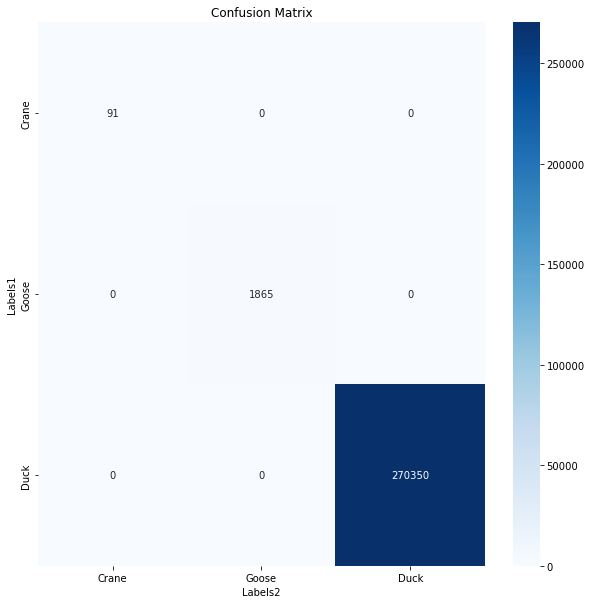

In [27]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Add labels and title
ax.set_xlabel('Labels2')
ax.set_ylabel('Labels1')
ax.set_title('Confusion Matrix')

# Add class names as tick labels
ax.set_xticklabels(list(class_map2.values()))
ax.set_yticklabels(list(class_map1.values()))

plt.show()